<a href="https://colab.research.google.com/github/ik-okoro/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Ik's_Unit_2_1_3_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ridge Regression
- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    !pip install category_encoders==2.*

# Wrangle Data

## Import

In [8]:
import numpy as np
import pandas as pd

df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', parse_dates=['created'],
                 index_col='created')

In [3]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info

<bound method DataFrame.info of                      bathrooms  ...  common_outdoor_space
created                         ...                      
2016-06-24 07:54:24        1.5  ...                     0
2016-06-12 12:19:27        1.0  ...                     0
2016-04-17 03:26:41        1.0  ...                     0
2016-04-18 02:22:02        1.0  ...                     0
2016-04-28 01:32:41        1.0  ...                     0
...                        ...  ...                   ...
2016-06-02 05:41:05        1.0  ...                     0
2016-04-04 18:22:34        1.0  ...                     1
2016-04-16 02:13:40        1.0  ...                     0
2016-04-08 02:13:33        1.0  ...                     0
2016-04-12 02:48:07        1.0  ...                     0

[49352 rows x 33 columns]>

## EDA

In [5]:
df["elevator"].value_counts()

1    25916
0    23436
Name: elevator, dtype: int64

In [6]:
df["interest_level"].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [7]:
# Bare outliers
round(df.describe()["price"], 2)

count      49352.00
mean        3830.17
std        22066.87
min           43.00
25%         2500.00
50%         3150.00
75%         4100.00
max      4490000.00
Name: price, dtype: float64

In [15]:
def wrangle(df):
  df = df.copy()
  df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  hc_cols = [col for col in df.select_dtypes("object").columns if df[col].nunique() > 5] # look below for high cardinality

  df.drop(columns=hc_cols, inplace=True)
  
  return df

In [16]:
df = wrangle(df)

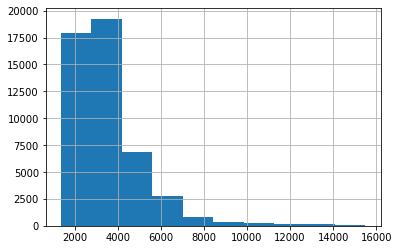

In [11]:
df["price"].hist()

In [12]:
df.select_dtypes("object").head()

,description,display_address,street_address,interest_level
created,,,,
2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,792 Metropolitan Avenue,medium
2016-06-12 12:19:27,,Columbus Avenue,808 Columbus Avenue,low
2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,241 W 13 Street,high
2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,333 East 49th Street,low
2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,500 West 143rd Street,low


In [13]:
df.select_dtypes("object").nunique()

description        37853
display_address     8674
street_address     15135
interest_level         3
dtype: int64

These columns have high cardinality. Best to drop them

In [14]:
hc_cols = [col for col in df.select_dtypes("object").columns if df[col].nunique() > 5]

In [17]:
# After wrangling
df.select_dtypes("object").nunique()

interest_level    3
dtype: int64

# Split Data

## Split Feature Matrix from Target Vector

In [18]:
target = "price"
y = df[target]
X = df.drop(columns = target)

## Split Data into Training and Test sets

In [19]:
cutoff = "2016-06-01"
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# Establish Baseline

Is this a regression or classification problem? Regression because we're predicting a continous variable, price

In [20]:
y_train.mean()

3534.0363428788887

In [21]:
from sklearn.metrics import mean_absolute_error

In [24]:
mean_absolute_error(y_train, ([y_train.mean()]*len(y_train)))

1141.4828519405287

# Build `LinearRegression` Model

Our model will have three components:

1. `transformer_1`: `OneHotEncoder`
2. `transformer_2`: `SelectKBest`
3. `predictor`: `LinearRegression`


## Transformer 1: `OneHotEncoder`

In [25]:
print(len(X_train.columns))
X_train.columns

29


Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [26]:
# Step 1: Import the transformer class
from category_encoders import OneHotEncoder

# Step 2: Instantiate
ohe = OneHotEncoder(use_cat_names=True)

# Step 3: Fit your training data to the transformer
ohe.fit(X_train)

# Step 4: Transform
XT_train = ohe.transform(X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [27]:
print(len(XT_train.columns))
XT_train.columns

31


Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level_high',
       'interest_level_low', 'interest_level_medium', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

In [28]:
XT_train[['interest_level_high', 'interest_level_low', 'interest_level_medium']].head()

,interest_level_high,interest_level_low,interest_level_medium
created,,,
2016-04-17 03:26:41,1,0,0
2016-04-18 02:22:02,0,1,0
2016-04-28 01:32:41,0,1,0
2016-04-19 04:24:47,0,0,1
2016-04-27 03:19:56,0,1,0


## `StandardScaler`

In [29]:
X_train.describe()

,bathrooms,bedrooms,latitude,longitude,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
count,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000,31533.000000
mean,1.197190,1.524118,40.750838,-73.973154,0.530302,0.477309,0.482003,0.445882,0.431009,0.418990,0.370532,0.057590,0.267529,0.186313,0.174357,0.133860,0.143913,0.102813,0.088859,0.060223,0.055466,0.051375,0.047189,0.041702,0.044017,0.038816,0.028351,0.029176
std,0.459265,1.102005,0.037963,0.027915,0.499089,0.499493,0.499684,0.497071,0.495225,0.493402,0.482955,0.232971,0.442678,0.389365,0.379422,0.340507,0.351007,0.303719,0.284545,0.237903,0.228891,0.220764,0.212046,0.199911,0.205137,0.193160,0.165977,0.168302
min,0.000000,0.000000,40.576500,-74.035800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,40.728600,-73.991800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.751700,-73.978200,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,40.773500,-73.955200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,7.000000,40.888000,-73.779100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(XT_train)

XTT_train = ss.transform(XT_train)

## `LinearRegression`

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(XTT_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Check Metrics

In [32]:
print("Training MAE:", mean_absolute_error(y_train, model.predict(XTT_train)))

Training MAE: 630.0342923218755


In [34]:
# Transform test data WITHOUT FITTING
XT_test = ohe.transform(X_test)
XTT_test = ss.transform(XT_test)
mean_absolute_error(y_test, model.predict(XTT_test))

638.09435166101

# Build `RidgeRegression` Model

In [39]:
from sklearn.linear_model import Ridge

In [40]:
Ridge?

A **hyperparamter** is a setting that you determine *before* you fit your model that will determine/shape/affect the fitting process

In [41]:
model2 = Ridge(alpha=5, normalize=False) # alpha is a hyperparameter example

model2.fit(XTT_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [42]:
print("RIDGE train MAE:", mean_absolute_error(y_train, model2.predict(XTT_train)))
print("RIDGE test MAE:", mean_absolute_error(y_test, model2.predict(XTT_test)))

RIDGE train MAE: 630.0487321239738
RIDGE test MAE: 638.1131986879337


# Communicate Results

## `LinearRegression`

In [36]:
coefficients = model.coef_.round(2)
features = XT_train.columns

feat_importances = pd.Series(coefficients, index = features).sort_values(key = lambda x: abs(x))

feat_importances

cats_allowed            -8.660000e+00
swimming_pool            9.800000e+00
balcony                 -1.337000e+01
garden_patio            -1.541000e+01
outdoor_space           -1.550000e+01
loft                     1.785000e+01
dogs_allowed             2.727000e+01
laundry_in_building     -2.909000e+01
exclusive                3.027000e+01
terrace                  3.031000e+01
wheelchair_access        3.115000e+01
dishwasher               3.135000e+01
pre-war                 -3.272000e+01
common_outdoor_space    -3.344000e+01
new_construction        -3.469000e+01
no_fee                  -4.122000e+01
latitude                 4.199000e+01
fitness_center           4.739000e+01
roof_deck               -5.955000e+01
dining_room              6.058000e+01
hardwood_floors         -6.827000e+01
high_speed_internet     -7.414000e+01
elevator                 8.382000e+01
laundry_in_unit          1.589700e+02
doorman                  2.019000e+02
longitude               -3.853800e+02
bedrooms    

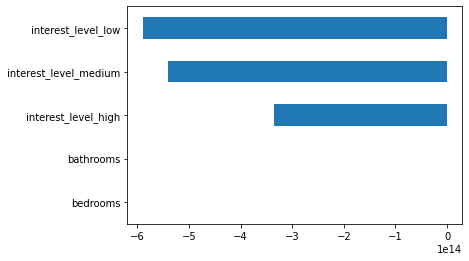

In [37]:
feat_importances.tail().plot(kind = "barh");

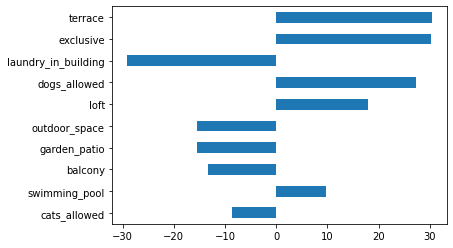

In [38]:
feat_importances.head(10).plot(kind = "barh")

## Ridge

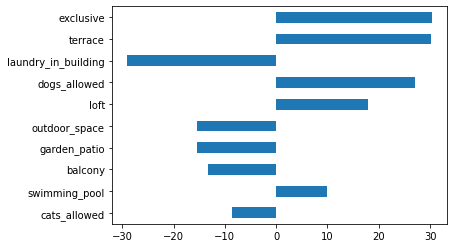

In [43]:
# Get coefficients from model
coefficients = np.round(model2.coef_, 2)
features = XT_train.columns

# Create series with coefs and feat names
feat_importances = pd.Series(coefficients, index=features).sort_values(key=lambda x: abs(x))

# Plot feature importances
feat_importances.head(10).plot(kind='barh');

This data set doesn't really need regularization